In [1]:
#@title Autoload all modules
%load_ext autoreload
%autoreload 2

from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import io
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import importlib
import os
import functools
import itertools
import torch
from losses import get_optimizer
from models.ema import ExponentialMovingAverage

import torch.nn as nn
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
import tqdm
import io
import likelihood
import controllable_generation
from utils import restore_checkpoint
sns.set(font_scale=2)
sns.set(style="whitegrid")

import models
from models import utils as mutils
from models import ddpm as ddpm_model
import sampling
from likelihood import get_likelihood_fn
from sde_lib import VESDE, VPSDE, subVPSDE
from sampling import (ReverseDiffusionPredictor, 
                      LangevinCorrector, 
                      EulerMaruyamaPredictor, 
                      AncestralSamplingPredictor, 
                      NoneCorrector, 
                      NonePredictor,
                      AnnealedLangevinDynamics)
import datasets
from configs.vp import cifar10_ddpm_continuous as configs

/home/yifulu/.conda/envs/dpm/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config=configs.get_config()
sde = VPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
sampling_eps = 1e-3

In [3]:
img_size = config.data.image_size
channels = config.data.num_channels
lst_steps = torch.tensor([1.0,0.950049877166748,0.9000999927520752,0.8501499891281128,
0.8001999258995056,0.750249981880188,0.7002999782562256,
0.6503499746322632,0.6003999710083008,0.5504499673843384,
0.5004999041557312,0.4505499303340912,0.40059995651245117,
0.35064995288848877,0.30069997906684875,0.25074997544288635,
0.20079998672008514,0.15084998309612274,0.10090000182390213,
0.050950001925230026,0.0010000000474974513,0])
lst_steps = torch.flip(lst_steps,(0,))
noise_size = lst_steps.shape[0]
batch_size=1
shape = (batch_size, channels, img_size, img_size)
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

In [4]:
#@title Visualization code

def image_grid(x):
  size = config.data.image_size
  channels = config.data.num_channels
  img = x.reshape(-1,size, size, channels)
  
  img = img.reshape((batch_size, noise_size, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((batch_size*size, noise_size * size, channels))
  return img
"""
def image_grid(x):
  size = config.data.image_size
  channels = config.data.num_channels
  img = x.reshape(-1, size, size, channels)
  w = int(np.sqrt(img.shape[0]))
  img = img.reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
  return img
"""
def show_samples(x):
  x = x.permute(0, 2, 3, 1).detach().cpu().numpy()
  #x = x.detach().cpu().numpy()
  img = image_grid(x)
  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(img)
  plt.show()


In [5]:
_, eval_ds, _ = datasets.get_dataset(config,
                                              uniform_dequantization=config.data.uniform_dequantization)
eval_iter = iter(eval_ds)  # pytype: disable=wrong-arg-types
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
batch = torch.from_numpy(next(eval_iter)['image']._numpy()).to(config.device).float()
batch = scaler(batch)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2023-02-13 20:33:40.512357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /sw/pkgs/arc/cudnn/11.3-v8.2.1/lib64:/sw/pkgs/arc/cuda/11.3.0/lib64:/opt/slurm/lib64::
2023-02-13 20:33:40.512383: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
batch = batch.permute(0, 3, 1, 2)

batch = batch.repeat(noise_size,1,1,1)
print(batch.shape)

torch.Size([22, 3, 32, 32])


In [7]:
t = lst_steps.to(batch.device)
z = torch.randn_like(batch)
mean, std = sde.marginal_prob(batch, t.repeat(batch_size))
perturbed_data = mean + std[:, None, None, None] * z


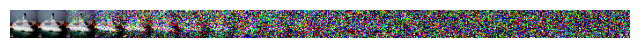

In [8]:
show_samples(perturbed_data)